In [1]:
import numpy as np
from scipy.stats._continuous_distns import genpareto
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pathlib import Path
import netCDF4 as nc
import importlib
import stme
from pathlib import Path
from datetime import datetime
from search_coord import search_coord

In [2]:
# %%Config
thr_org = np.array([6, 20])
thr_gum = 1.25

# %%Mkdir
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d-%H%M")
# dir_out = f"./output/temp/"
dir_out = f"./output/common/"
path_out = Path(dir_out)
if not path_out.exists():
    path_out.mkdir()


# %%Load STM & Exposure
fl = list(Path("./summary_data").glob("*.nc"))
num_events = len(fl)
num_vars = 2
num_nodes = nc.Dataset(fl[0]).dimensions["node"].size
stm_h = np.zeros((num_events))
stm_u = np.zeros((num_events))
stm_h_coord = np.zeros((num_events, 2))
stm_u_coord = np.zeros((num_events, 2))
is_e_h = np.full((num_events), False)
is_e_u = np.full((num_events), False)
is_me_h = np.full((num_events), False)
is_me_u = np.full((num_events), False)
exp_h = np.zeros((num_events, num_nodes))
exp_u = np.zeros((num_events, num_nodes))
latlon_ds = nc.Dataset("latlon.nc")
latlon = np.array([latlon_ds["lat"][:], latlon_ds["lon"][:]]).T
rng = np.random.default_rng()

for i, fp in enumerate(fl):
    ds = nc.Dataset(fp)
    # if i == 1:
    #     print(ds)
    stm_h[i], stm_u[i] = ds["stm_h"][:], ds["stm_u"][:]
    stm_h_coord[i, :], stm_u_coord[i, :] = ds["stm_h_coord"][:], ds["stm_u_coord"][:]
    exp_h[i, :], exp_u[i, :] = ds["exp_h"][:], ds["exp_u"][:]
    # ts[ds['scenario'][:]-1] = ds['track'][:]

stm = np.stack((stm_h, stm_u), axis=1)
exp = np.stack((exp_h, exp_u), axis=2)
var_name = ["$H_s$", "$U$"]
var_name_g = ["$\hat H_s$", "$\hat U$"]
unit = ["[m]", "[m/s]"]
pos_color = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# %%Saint Denis
idx_pos_list_saint_denis = []
for i in range(4):
    idx_pos_list_saint_denis.append(search_coord(-20.882057 + 0.1 * i, 55.450675))

In [3]:
N = 500
genpar_params = np.zeros((N, 3, num_vars))
gp = [None, None]

for vi in range(num_vars):
    _stm_bootstrap = rng.choice(stm[:, vi], size=(N, stm[:, vi].shape[0]))
    for i in range(N):
        _stm = _stm_bootstrap[i, :]
        _stm_pot = _stm[_stm > thr_org[vi]]
        _xp, _mp, _sp = genpareto.fit(_stm_pot, floc=thr_org[vi])
        genpar_params[i, :, vi] = [_xp, _mp, _sp]
    # xp, mp, sp = np.percentile(genpar_params[:,:,vi],50.0,axis=0)
    xp, mp, sp = np.mean(genpar_params[:, :, vi], axis=0)
    print(f"GENPAR{xp, mp, sp}")
    gp[vi] = genpareto(xp, mp, sp)

GENPAR(-0.5601015115842579, 6.0, 6.932683478590526)
GENPAR(-0.8427950638752008, 20.0, 30.680573198470874)


In [4]:
importlib.reload(stme)
stm_g = np.zeros(stm.shape)
f_hat_cdf = [None, None]
for vi in range(num_vars):
    f_hat_cdf[vi] = lambda x, idx=vi: stme._f_hat_cdf(ECDF(stm[:, idx]), gp[idx], x)
    _stm = stm[:, vi]
    stm_g[:, vi] = -np.log(-np.log(f_hat_cdf[vi](_stm)))
# print(stm_g[:,0].argmax(), stm_g[:,1].argmax())
print(stm_g[:, 0].max(), stm_g[:, 1].max())
print(stm_g[:, 0].min(), stm_g[:, 1].min())

9.049323422772217 7.022459393885472
-1.81929624325458 -1.81929624325458


In [5]:
is_e_hg = stm_g[:, 0] > thr_gum
is_e_ug = stm_g[:, 1] > thr_gum
is_me_hg = np.logical_and(stm_g[:, 0] > stm_g[:, 1], is_e_hg)
is_me_ug = np.logical_and(stm_g[:, 1] > stm_g[:, 0], is_e_ug)
is_e = np.stack((is_e_hg, is_e_ug), axis=1)
is_me = np.stack((is_me_hg, is_me_ug), axis=1)

In [6]:
N = 1000
stm_g_rep = np.zeros((N, *stm_g.shape))
for i in range(N):
    _idx = rng.choice(stm_g.shape[0], size=stm_g.shape[0])
    _stm = stm_g[_idx, :]
    for vi in range(num_vars):
        _gumbel_sample = rng.gumbel(loc=0, scale=1, size=_stm[:, vi].shape[0])
        _gumbel_sample_sorted = np.sort(_gumbel_sample)
        _arg = np.argsort(_stm[:, vi])
        stm_g_rep[i, _arg, vi] = _gumbel_sample_sorted

## Grid search gumbel threshold

In [7]:
N_THR = 10
thr_gum_list = np.linspace(0,3,N_THR)

lb = [0, None, -5, 0]
ub = [1, 1, 5, 5]
N = stm_g_rep.shape[0]
params_search_uc = np.zeros((N_THR, N, 4, num_vars))
for ti in range(N_THR):
  _thr = thr_gum_list[ti]
  for i in range(N):
      for vi in range(num_vars):
          a0 = np.random.uniform(low=lb[0], high=ub[0])
          b0 = np.random.uniform(low=-1, high=ub[1])
          m0 = np.random.uniform(low=-1, high=1)
          s0 = np.random.uniform(low=lb[3], high=1)

          evt_mask = stm_g_rep[i, :, vi] > _thr
          var_mask = np.full((stm_g_rep[i].shape[1]), True)
          var_mask[vi] = False

          def func(x):
              return stme.cost(
                  x, stm_g_rep[i, evt_mask, vi], stm_g_rep[i, evt_mask, var_mask]
              )

          optres = minimize(
              func,
              np.array([a0, b0, m0, s0]),
              # method='trust-constr',
              bounds=((lb[0], ub[0]), (lb[1], ub[1]), (lb[2], ub[2]), (lb[3], ub[3])),
          )
          _param = optres.x
          params_search_uc[ti, i, :, vi] = _param
params_median = np.median(params_search_uc, axis=1)
params_u95 = np.percentile(params_search_uc,97.5,axis=1)
params_l95 = np.percentile(params_search_uc, 2.5,axis=1)
params_u75 = np.percentile(params_search_uc,75.0,axis=1)
params_l25 = np.percentile(params_search_uc,25.0,axis=1)

c:\Users\ksksn\dev\stme-reunion\stme.py:87: RuntimeWarning: divide by zero encountered in log
  np.log(sigma * ydata ** b)
c:\Users\ksksn\dev\stme-reunion\stme.py:89: RuntimeWarning: divide by zero encountered in true_divide
  * ((xdata[:, vi] - (a * ydata + mu * ydata ** b)) / (sigma * ydata ** b))
c:\Users\ksksn\dev\stme-reunion\stme.py:87: RuntimeWarning: invalid value encountered in add
  np.log(sigma * ydata ** b)
c:\Users\ksksn\dev\stme-reunion\stme.py:87: RuntimeWarning: overflow encountered in power
  np.log(sigma * ydata ** b)
c:\Users\ksksn\dev\stme-reunion\stme.py:87: RuntimeWarning: invalid value encountered in multiply
  np.log(sigma * ydata ** b)
c:\Users\ksksn\dev\stme-reunion\stme.py:89: RuntimeWarning: overflow encountered in power
  * ((xdata[:, vi] - (a * ydata + mu * ydata ** b)) / (sigma * ydata ** b))
c:\Users\ksksn\dev\stme-reunion\stme.py:89: RuntimeWarning: overflow encountered in multiply
  * ((xdata[:, vi] - (a * ydata + mu * ydata ** b)) / (sigma * ydata ** 

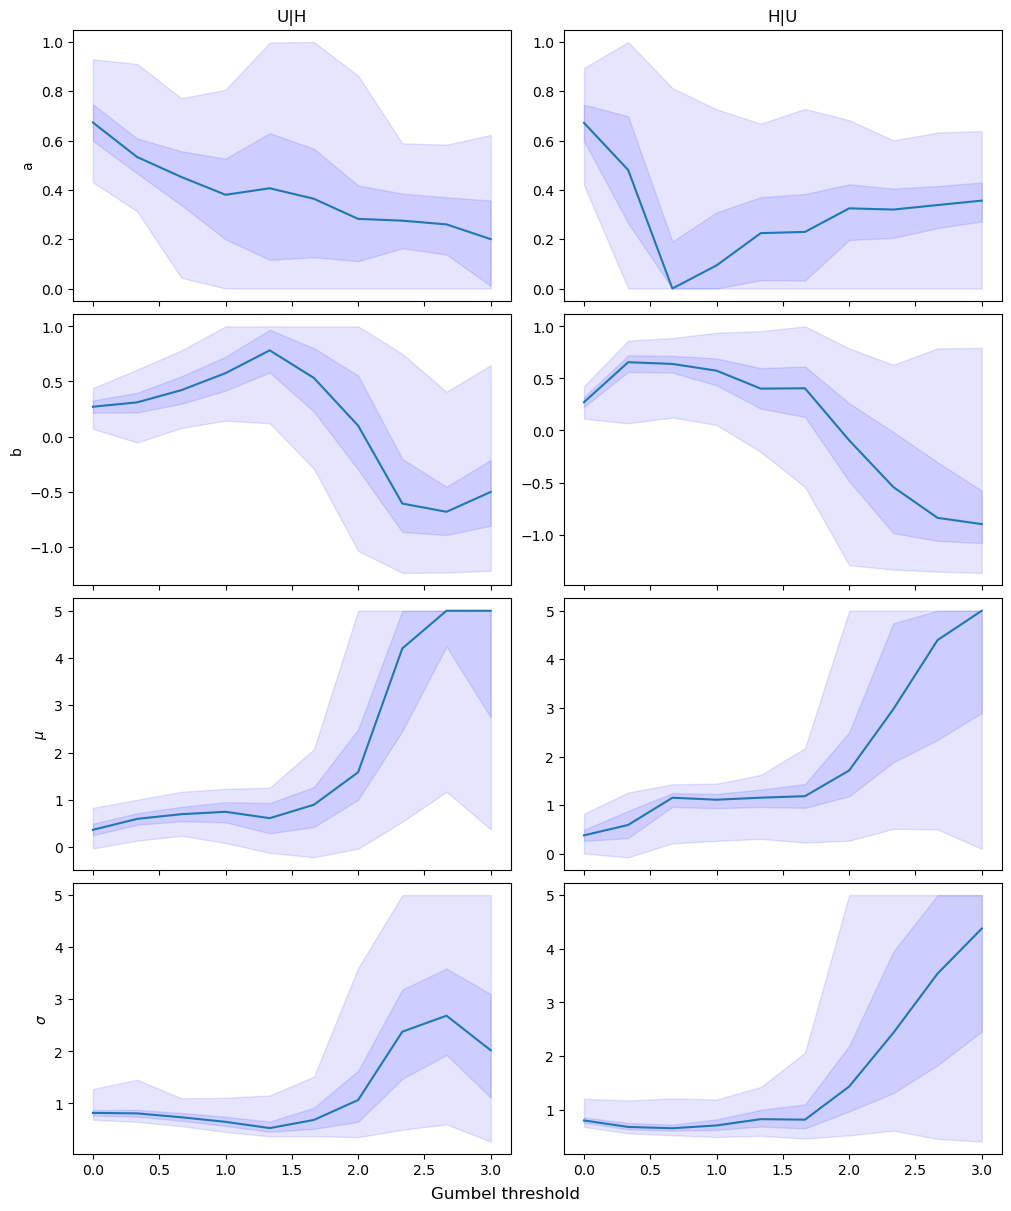

In [11]:
fig, ax = plt.subplots(4,2,sharex=True, figsize=(10,12),dpi=100,constrained_layout=True)
# fig.tight_layout()
# fig.con
fig.supxlabel("Gumbel threshold")
fig.set_facecolor('white')
p_name = ['a','b','$\mu$','$\sigma$']
m_name = ['U|H', 'H|U']
for vi in range(num_vars):
    ax[0,vi].set_title(m_name[vi])
    # ax[0,vi].set_title(var_name[vi])
    for pi in range(4):
        # ax[pi,vi].plot(thr_gum_list, params_mean[:,pi,vi])
        ax[pi,vi].plot(thr_gum_list, params_median[:,pi,vi])
        ax[pi,vi].fill_between(thr_gum_list,params_u95[:,pi,vi],params_l95[:,pi,vi],color='blue',alpha=0.1)
        ax[pi,vi].fill_between(thr_gum_list,params_u75[:,pi,vi],params_l25[:,pi,vi],color='blue',alpha=0.1)
        ax[pi,0].set_ylabel(p_name[pi])
plt.savefig(f"{dir_out}/Conmul_param_vs_threshold.png", bbox_inches="tight")

In [9]:
num_samples = np.zeros((N_THR, N, num_vars))
for ti in range(N_THR):
    for i in range(N):
        for vi in range(num_vars):
            num_samples[ti,i,vi] = np.count_nonzero(stm_g_rep[i, :, vi] > thr_gum_list[ti])

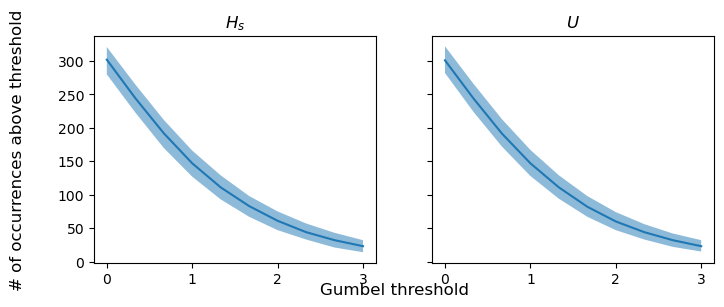

In [14]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,3),dpi=100,facecolor='white')
# fig.tight_layout()
fig.supxlabel("Gumbel threshold")
fig.supylabel("# of occurrences above threshold")

_med = np.percentile(num_samples,50,axis=1)
_u95 = np.percentile(num_samples,97.5,axis=1)
_l95 = np.percentile(num_samples, 2.5,axis=1)
for vi in range(num_vars):
    ax[vi].plot(thr_gum_list, _med[:,vi])
    ax[vi].fill_between(thr_gum_list, _u95[:,vi], _l95[:,vi],alpha=0.5)
    ax[vi].set_title(var_name[vi])

plt.savefig(f"{dir_out}/Conmul_sample_num.png", bbox_inches="tight")